### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder

### Get gripper joint indexes

In [3]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx not in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [6, 7, 8, 9, 10, 11]


In [4]:
q_init = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_close_grasp = [-0.03, -0.0273, -0.03, 0.03, 0.0273, 0.03]

### Solve `General` form of Inverse Kinematics on `Mujoco Engine`
#### Doesn't consider the `collisions`

In [5]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.7, -0.2, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_init),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, w_weight=0.5)

# Close viewer
env.close_viewer()
print ("Done.")

print(f"Solved joint q values: {q_ik}")

Done.
Solved joint q values: [-0.72 -1.19  1.9   2.42 -0.85 -3.14]


Pressed ESC
Quitting.


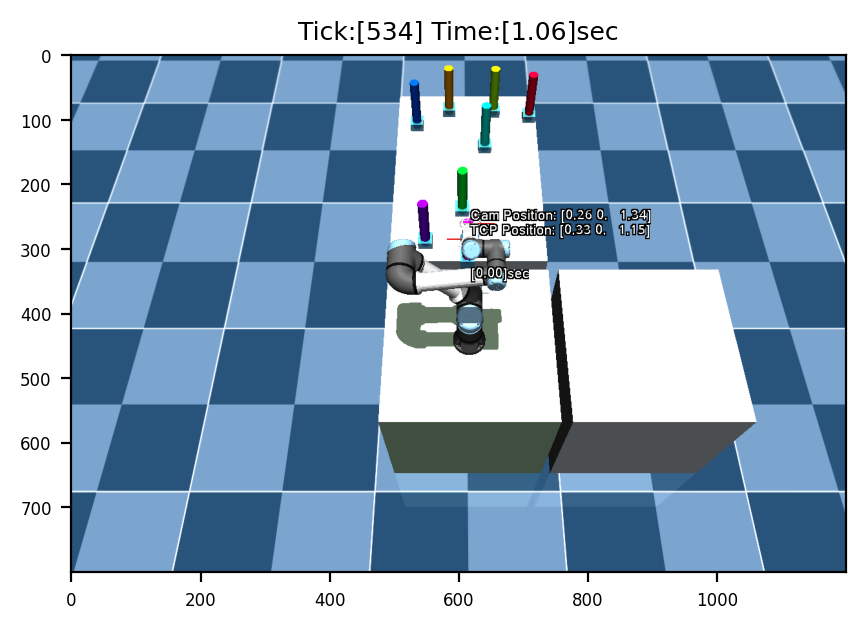

Done.


In [11]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
# Starts with this joint configuration.
env.forward(q=q_init, joint_idxs=env.idxs_forward)
env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=env.idxs_forward)
    env.step(ctrl=0.1, ctrl_idxs=[6]) # open gripper
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")